# PhaseNet Example

Applying GaMMA to associate PhaseNet picks

In [1]:
# !pip install git+https://github.com/wayneweiqiang/GaMMA.git

In [2]:
import pandas as pd
from gamma.utils import association, estimate_eps
import numpy as np
import os
from pyproj import Proj
import json
import matplotlib.pyplot as plt

/tmp/ipykernel_58764/2885422005.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Download demo data

There are two examples in the demo data: Ridgecrest, CA and Chile.

**Phase Picks**:
- test_data/ridgecrest
    - picks.csv
    - stations.csv
    - standard_catalog.csv
- test_data/chile
    - picks.csv
    - stations.csv
    - iasp91.csv

**Results**:
- test_data/ridgecrest
    - gamma_events.csv
    - gamma_picks.csv
- test_data/chile
    - gamma_events.csv
    - gamma_picks.csv

In [3]:
!if [ -f demo.tar ]; then rm demo.tar; fi
!if [ -d test_data ]; then rm -rf test_data; fi
!wget -q https://github.com/AI4EPS/GaMMA/releases/download/test_data/demo.tar
!tar -xf demo.tar

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'


In [4]:
# region = "ridgecrest"
# region = "chile"
region = "ncedc"
data_path = lambda x: os.path.join(f"test_data/{region}", x)
result_path = f"results/{region}"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_path = lambda x: os.path.join(f"results/{region}", x)
station_csv = data_path("stations.csv")
station_json = data_path("stations.json")
picks_csv = data_path("picks.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

In [5]:
## read picks
picks = pd.read_csv(picks_csv, parse_dates=["phase_time"])
picks.rename(columns={"station_id": "id", "phase_time": "timestamp", "phase_type": "type", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)
print("Pick format:", picks.iloc[:3])

## read stations
# stations = pd.read_csv(station_csv)
# stations.rename(columns={"station_id": "id"}, inplace=True)
stations = pd.read_json(station_json, orient="index")
stations["id"] = stations.index
print("Station format:", stations.iloc[:3])

## Automatic region; you can also specify a region
with open(data_path("config.json"), "r") as f:
    config = json.load(f)
    config["center"] = ((config["minlongitude"] + config["maxlongitude"]) / 2, (config["minlatitude"] + config["maxlatitude"]) / 2)
    config["xlim_degree"] = (config["minlongitude"], config["maxlongitude"])
    config["ylim_degree"] = (config["minlatitude"], config["maxlatitude"])

# x0 = stations["longitude"].median()
# y0 = stations["latitude"].median()
# xmin = stations["longitude"].min()
# xmax = stations["longitude"].max()
# ymin = stations["latitude"].min()
# ymax = stations["latitude"].max()
# config = {}
# config["center"] = (x0, y0)
# config["xlim_degree"] = (2 * xmin - x0, 2 * xmax - x0)
# config["ylim_degree"] = (2 * ymin - y0, 2 * ymax - y0)

## projection to km
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)
stations = stations[(stations["longitude"] > config["minlongitude"]) & (stations["longitude"] < config["maxlongitude"]) & (stations["latitude"] > config["minlatitude"]) & (stations["latitude"] < config["maxlatitude"])]
picks = picks[picks["id"].isin(stations["id"])]

### setting GMMA configs
config["use_dbscan"] = True
if region == "chile":
    config["use_amplitude"] = False
else:
    config["use_amplitude"] = True
config["method"] = "BGMM"  
if config["method"] == "BGMM": ## BayesianGaussianMixture
    config["oversample_factor"] = 5
if config["method"] == "GMM": ## GaussianMixture
    config["oversample_factor"] = 1

# config["covariance_prior"] = [1000.0, 1000.0]

# earthquake location
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["x(km)"] = proj(longitude=config["xlim_degree"], latitude=[config["center"][1]] * 2)[0]
config["y(km)"] = proj(longitude=[config["center"][0]] * 2, latitude=config["ylim_degree"])[1]

if region == "ridgecrest":
    config["z(km)"] = (0, 20)
elif region == "chile":
    config["z(km)"] = (0, 250)
else:
    config["z(km)"] = (0, 30)
    print("Please specify z(km) for your region")
    # raise NotImplementedError
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # z
    (None, None),  # t
)

# DBSCAN
config["dbscan_eps"] = 10 #estimate_eps(stations, config["vel"]["p"])
config["dbscan_min_samples"] = 3

## using Eikonal for 1D velocity model
if region == "ridgecrest":
    zz = [0.0, 5.5, 16.0, 32.0]
    vp = [5.5, 5.5,  6.7,  7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 1.0
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
elif region == "chile":
    velocity_model = pd.read_csv(data_path("iasp91.csv"), names=["zz", "rho", "vp", "vs"])
    velocity_model = velocity_model[velocity_model["zz"] <= config["z(km)"][1]]
    vel = {"z": velocity_model["zz"].values, "p": velocity_model["vp"].values, "s": velocity_model["vs"].values}
    h = 1.0
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
else:
    print("Using uniform velocity model")

if region == "chile":
    config["initial_points"] = [1, 1, 1] # x, y, z

# set number of cpus
config["ncpu"] = 32

# filtering
config["min_picks_per_eq"] = 5
config["min_p_picks_per_eq"] = 0
config["min_s_picks_per_eq"] = 0
config["max_sigma11"] = 3.0*5 # second
config["max_sigma22"] = 1.0*3 # log10(m/s)
config["max_sigma12"] = 1.0*3 # covariance

## filter picks without amplitude measurements
if config["use_amplitude"]:
    picks = picks[picks["amp"] != -1]

for k, v in config.items():
    print(f"{k}: {v}")


Pick format:            id               timestamp   prob type       amp  \
0  BG.AL1..DP 2023-01-01 18:35:33.390  0.349    P  0.000007   
1  BG.AL1..DP 2023-01-01 18:50:19.400  0.374    P  0.000001   
2  BG.AL1..DP 2023-01-01 18:50:23.780  0.519    S  0.000001   

                begin_time  phase_index    dt  
0  2023-01-01T00:00:00.000      6693339  0.01  
1  2023-01-01T00:00:00.000      6781940  0.01  
2  2023-01-01T00:00:00.000      6782378  0.01  
Station format:            network station location instrument component  \
AZ.KNW..BH      AZ     KNW                  BH     12ENZ   
AZ.KNW..EH      AZ     KNW                  EH       12Z   
AZ.KNW..HH      AZ     KNW                  HH     12ENZ   

                                                  sensitivity  latitude  \
AZ.KNW..BH  [839091000.0, 209773000.0, 839091000.0, 209773...   33.7141   
AZ.KNW..EH  [31432900.0, 15716500.0, 31432900.0, 15716500....   33.7141   
AZ.KNW..HH  [157649000.0, 39412300.0, 840484000.0, 2101210..

In [6]:
from sklearn.cluster import DBSCAN
import matplotlib.dates as mdates

In [7]:
picks_ = picks.merge(stations[["id", "x(km)", "y(km)", "z(km)", "longitude", "latitude"]], on="id")
picks_["t"] = (picks_["timestamp"] - picks_["timestamp"].min()).dt.total_seconds()
data = picks_[["t", "x(km)", "y(km)", "z(km)"]].values

vel = np.average(config["vel"]["p"])
db = DBSCAN(eps=config["dbscan_eps"], min_samples=config["dbscan_min_samples"]).fit(data[:, :3] / np.array([1, vel, vel]))
labels = db.labels_
unique_labels = set(labels)
unique_labels = unique_labels.difference([-1])

lat0, lon0 = 40.409, -123.971
picks_["dist_km"] = np.sqrt((picks_["latitude"] - lat0)**2 + (picks_["longitude"] - lon0)**2) * 111.32
picks_["label"] = labels 
center = picks_.groupby("label").agg({"x(km)": "mean", "y(km)": "mean", "z(km)": "mean", "timestamp": "min", "latitude": "mean", "longitude": "mean"}).reset_index()
center["dist_km"] = np.sqrt((center["latitude"] - lat0)**2 + (center["longitude"] - lon0)**2) * 111.32


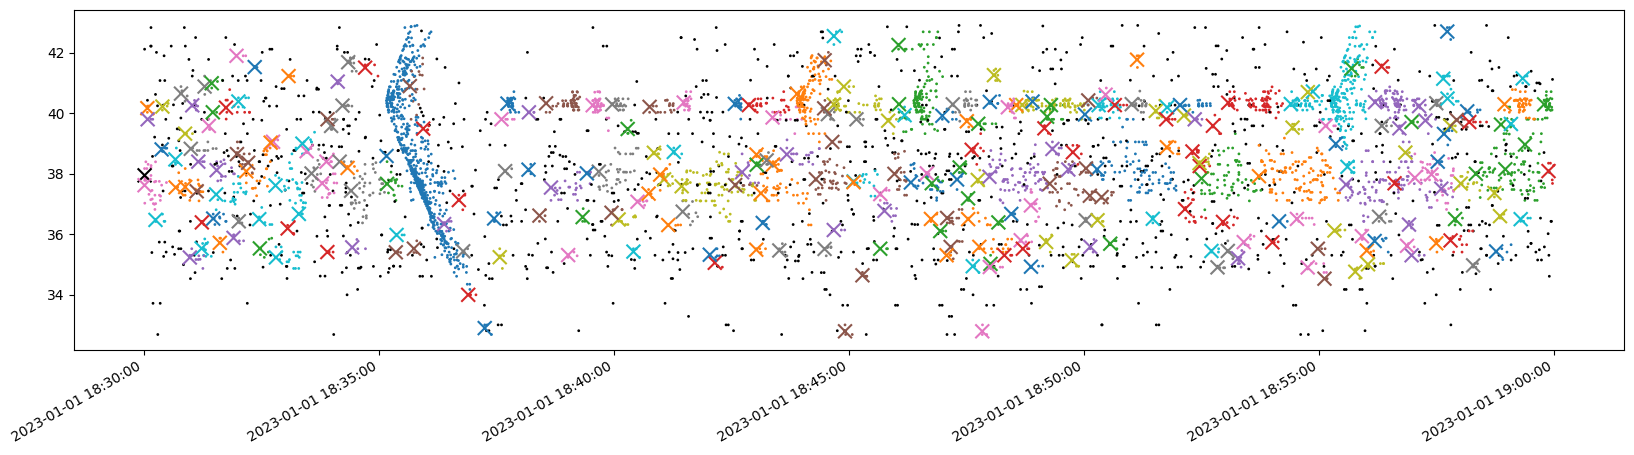

In [8]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], picks_["latitude"], c=picks_["label"].apply(mapping_color), s=1)
plt.scatter(center["timestamp"], center["latitude"], c=center["label"].apply(mapping_color), s=100, marker="x")
# plt set x time format to %Y-%m-%d %H:%M:%S
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()

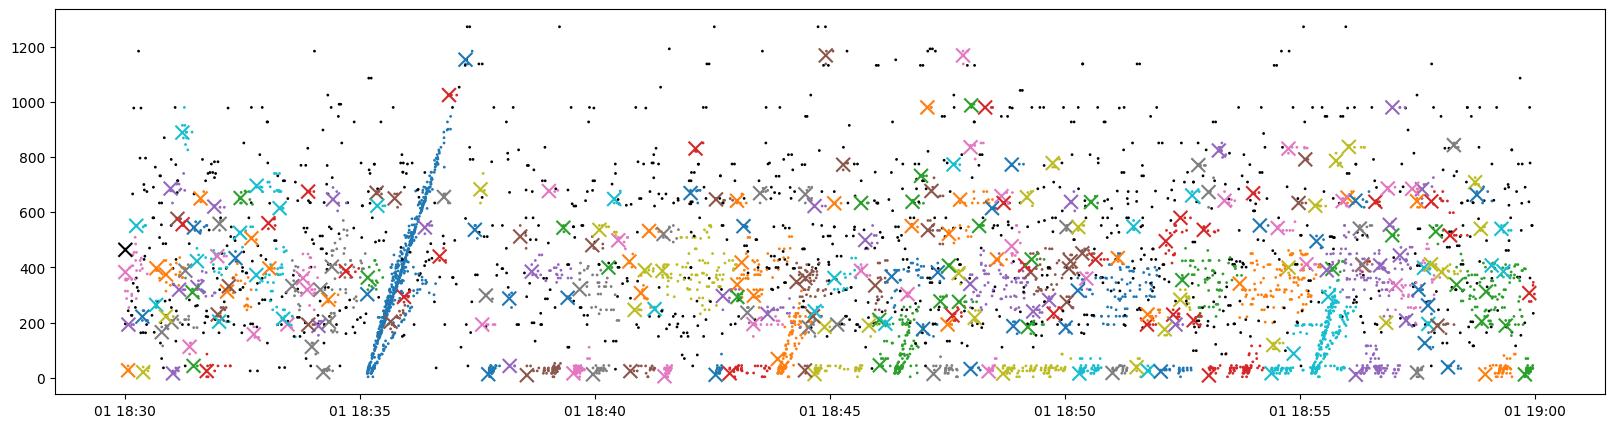

In [9]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], picks_["dist_km"], c=picks_["label"].apply(mapping_color), s=1)
plt.scatter(center["timestamp"], center["dist_km"], c=center["label"].apply(mapping_color), s=100, marker="x")

(19358.774305555555, 19358.777777777777)

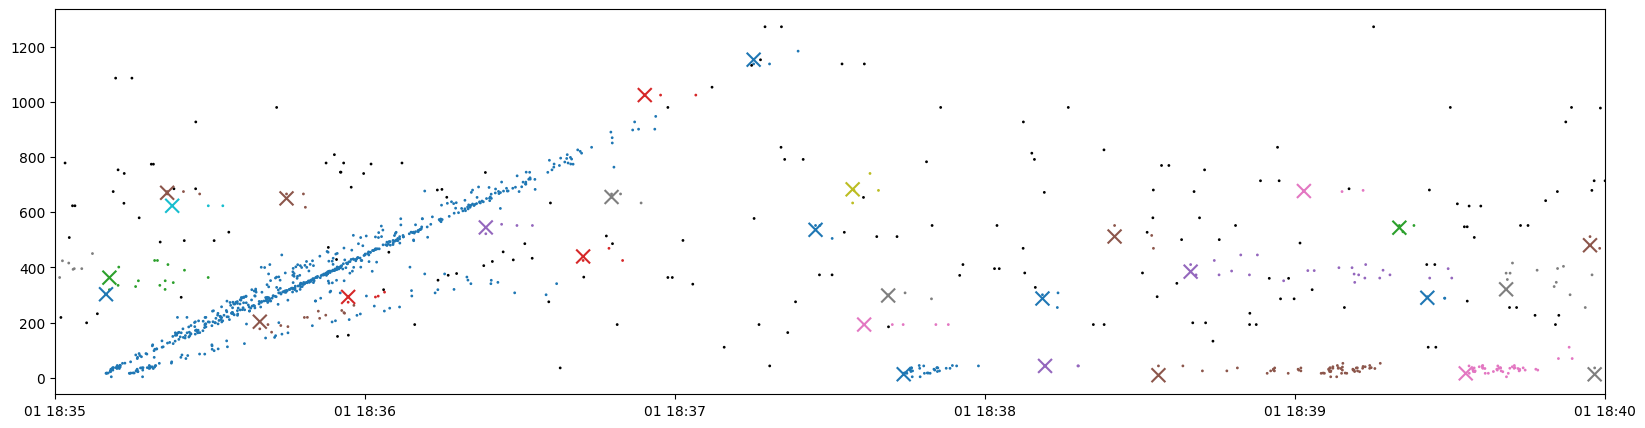

In [10]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], picks_["dist_km"], c=picks_["label"].apply(mapping_color), s=1)
plt.scatter(center["timestamp"], center["dist_km"], c=center["label"].apply(mapping_color), s=100, marker="x")
plt.xlim(pd.to_datetime("2023-01-01 18:35:00"), pd.to_datetime("2023-01-01 18:40:00"))

In [11]:
picks_window = picks_[(picks_["timestamp"] > pd.to_datetime("2023-01-01 18:35:00")) & (picks_["timestamp"] < pd.to_datetime("2023-01-01 18:37:00"))]

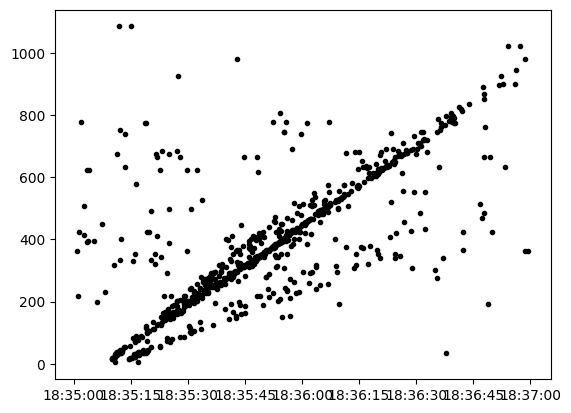

In [12]:
plt.figure()
plt.plot(picks_window["timestamp"], picks_window["dist_km"], "k.")

In [13]:
picks_window

,id,timestamp,prob,type,amp,begin_time,phase_index,dt,x(km),y(km),z(km),longitude,latitude,t,dist_km,label
0,BK.AASB.00.HH,2023-01-01 18:35:49.170,0.476,P,0.000007,2023-01-01T00:00:00.000,6694917,0.01,-140.566236,104.472114,-0.0658,-121.109750,38.430260,348.180,387.261842,0
5,BK.AONC.00.HH,2023-01-01 18:35:29.073,0.799,P,0.000043,2023-01-01T00:00:00.003,6692907,0.01,-218.961038,273.946479,-0.0669,-122.060800,39.939810,328.083,218.964015,0
8,BK.AONC.00.HH,2023-01-01 18:35:01.173,0.389,S,0.000001,2023-01-01T00:00:00.003,6690117,0.01,-218.961038,273.946479,-0.0669,-122.060800,39.939810,300.183,218.964015,-1
9,BK.AONC.00.HH,2023-01-01 18:35:48.293,0.390,S,0.000165,2023-01-01T00:00:00.003,6694829,0.01,-218.961038,273.946479,-0.0669,-122.060800,39.939810,347.303,218.964015,5
14,BK.BAKR.00.HH,2023-01-01 18:35:24.040,0.706,P,0.000133,2023-01-01T00:00:00.000,6692404,0.01,-254.611447,312.892997,-0.1901,-122.492261,40.280351,323.050,165.235017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5219,WR.SLD.10.HN,2023-01-01 18:36:04.280,0.790,P,0.000003,2023-01-01T00:00:00.000,6696428,0.01,-153.059809,-45.808513,-0.1360,-121.221222,37.074699,363.290,481.114199,0
5220,WR.SPR.10.HN,2023-01-01 18:35:20.390,0.678,P,0.000008,2023-01-01T00:00:00.000,6692039,0.01,-138.874745,-45.338183,-0.1150,-121.061836,37.081154,319.400,492.051956,-1
5227,WR.THER.00.HN,2023-01-01 18:35:34.470,0.410,P,0.000008,2023-01-01T00:00:00.000,6693447,0.01,-188.311791,222.507700,-0.0367,-121.688221,39.484103,333.480,274.184446,0
5228,WR.THER.00.HN,2023-01-01 18:35:35.050,0.495,P,0.000026,2023-01-01T00:00:00.000,6693505,0.01,-188.311791,222.507700,-0.0367,-121.688221,39.484103,334.060,274.184446,0


In [14]:
stations

,network,station,location,instrument,component,sensitivity,latitude,longitude,elevation_m,depth_km,x_km,y_km,z_km,provider,id,x(km),y(km),z(km)
AZ.KNW..BH,AZ,KNW,,BH,12ENZ,"[839091000.0, 209773000.0, 839091000.0, 209773...",33.714100,-116.711900,1507.0,-1.5070,258.718,-416.537,-1.507,NC,AZ.KNW..BH,258.718033,-416.537133,-1.5070
AZ.KNW..EH,AZ,KNW,,EH,12Z,"[31432900.0, 15716500.0, 31432900.0, 15716500....",33.714100,-116.711900,1507.0,-1.5070,258.718,-416.537,-1.507,NC,AZ.KNW..EH,258.718033,-416.537133,-1.5070
AZ.KNW..HH,AZ,KNW,,HH,12ENZ,"[157649000.0, 39412300.0, 840484000.0, 2101210...",33.714100,-116.711900,1507.0,-1.5070,258.718,-416.537,-1.507,NC,AZ.KNW..HH,258.718033,-416.537133,-1.5070
AZ.KNW..HN,AZ,KNW,,HN,ENZ,"[536936.0, 536936.0, 536936.0, 536936.0, 26846...",33.714100,-116.711900,1507.0,-1.5070,258.718,-416.537,-1.507,NC,AZ.KNW..HN,258.718033,-416.537133,-1.5070
AZ.LVA2..BH,AZ,LVA2,,BH,ENZ,"[839091000.0, 209773000.0, 789683000.0, 789683...",33.351601,-116.561501,1435.0,-1.4350,273.875,-456.385,-1.435,NC,AZ.LVA2..BH,273.874617,-456.384630,-1.4350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WR.STNI.10.HN,WR,STNI,10,HN,ENZ,"[213669.0, 213584.0, 214781.0]",38.119679,-121.540173,-0.7,0.0007,-178.905,70.734,0.001,NC,WR.STNI.10.HN,-178.904657,70.733524,0.0007
WR.THER.00.HN,WR,THER,00,HN,ENZ,"[856798.0, 856798.0, 856798.0, 857141.0, 85714...",39.484103,-121.688221,36.7,-0.0367,-188.312,222.508,-0.037,NC,WR.THER.00.HN,-188.311791,222.507700,-0.0367
WR.THER.01.HN,WR,THER,01,HN,ENZ,"[857141.0, 857141.0, 857141.0, 860562.0, 86056...",39.484142,-121.687941,44.0,-0.0440,-188.288,222.511,-0.044,NC,WR.THER.01.HN,-188.287593,222.511458,-0.0440
WR.THER.02.HN,WR,THER,02,HN,ENZ,"[851324.0, 851324.0, 851324.0, 851324.0, 85132...",39.484135,-121.688224,21.4,-0.0214,-188.312,222.511,-0.021,NC,WR.THER.02.HN,-188.311964,222.511260,-0.0214


In [15]:
import numpy as np
import scipy
from sklearn.base import BaseEstimator
from sklearn.linear_model import RANSACRegressor


class EQLoc(BaseEstimator):
    def __init__(self, config, event_t=None, event_loc=None):
        """
        event_t: float
        event_loc: np.array with shape (3)
        """
        xlim = config["xlim_km"]
        ylim = config["ylim_km"]
        zlim = config["zlim_km"]
        self.config = config

        if event_loc is not None:
            self.event_loc = event_loc
        else:
            self.event_loc = np.array([(xlim[0] + xlim[1]) / 2, (ylim[0] + ylim[1]) / 2, (zlim[0] + zlim[1]) / 2])
        if event_t is not None:
            self.event_t = event_t
        else:
            self.event_t = 0
        self.vel = {"P": 6.0, "S": 6.0 / 1.75}
        

    @staticmethod
    def loss(source, X, y, vel={"P": 6.0, "S": 6.0 / 1.75}):
        """
        X: data_frame with columns ["timestamp", "x_km", "y_km", "z_km", "type"] 
        """
        # dataframe
        # xyz = X[["x_km", "y_km", "z_km"]].values
        # v = X["vel"].values
        # numpy
        xyz = X[:, :3]
        v = X[:, 3]

        event_t = source[0]
        event_loc = source[1:]

        tt = np.linalg.norm(xyz - event_loc, axis=-1) / v + event_t
        loss = 0.5 * np.sum((tt - y)**2)

        J = np.zeros((len(X), 4))
        diff = tt - y
        J[:, 0] = diff
        J[:, 1:] = (event_loc - xyz) /  np.linalg.norm(xyz - event_loc, axis=-1, keepdims=True) / v[:,np.newaxis] * diff[:,np.newaxis]

        J = np.sum(J, axis=0)
        return loss, J

    def fit(self, X, y=None):
        
        opt = scipy.optimize.minimize(
            self.loss,
            x0 = np.array([self.event_t, *self.event_loc.ravel()]),
            method="L-BFGS-B",
            jac=True,
            args=(X, y), 
            # args=(phase_time, phase_type, station_loc, weight, vel, 1, eikonal),
            # bounds=bounds,
            # options={"maxiter": max_iter, "gtol": convergence, "iprint": -1},
        )

        self.event_t = opt.x[0]
        self.event_loc = opt.x[1:]
        self.is_fitted_ = True
        
        return self
    
    def predict(self, X):
        """
        X: data_frame with columns ["timestamp", "x_km", "y_km", "z_km", "type"] 
        """
        # dataframe
        # xyz = X[["x_km", "y_km", "z_km"]].values
        # v = X["vel"].values
        # numpy
        xyz = X[:, :3]
        v = X[:, 3]
        tt = np.linalg.norm(xyz - self.event_loc, axis=-1) / v + self.event_t
    
        return tt
    
    def score(self, X, y=None):
        """
        X: data_frame with columns ["timestamp", "x_km", "y_km", "z_km", "type"] 
        """
        tt = self.predict(X)
        R2 = 1 - np.sum((y - tt)**2) / np.sum((y - np.mean(y))**2)
        print(f"{R2=}")
        return R2
        

In [16]:
# https://earthquake.usgs.gov/earthquakes/eventpage/nc73827571/executive
lat0, lon0, z0 = 40.409, -123.971, 30.6
origin_time = pd.to_datetime("2023-01-01 18:35:04")
x0, y0 = proj(lon0, lat0)
print(f"{x0 = }, {y0 = }")

x0 = -379.7164208407868, y0 = 332.33303405425085


In [17]:
picks_window = picks_[(picks_["timestamp"] > pd.to_datetime("2023-01-01 18:35:00")) & (picks_["timestamp"] < pd.to_datetime("2023-01-01 18:37:00"))]
X = picks_window[["timestamp", "x(km)", "y(km)", "z(km)", "type"]].copy()
X.rename(columns={"x(km)": "x_km", "y(km)": "y_km", "z(km)": "z_km"}, inplace=True)
t0 = X["timestamp"].min()
config["vel"] = {"p": 7.5, "s": 7.5 / 1.75}
X.loc[:, "t_s"] = (X["timestamp"] - t0).dt.total_seconds().copy()
X["vel"] = X["type"].apply(lambda x: config["vel"][x.lower()])

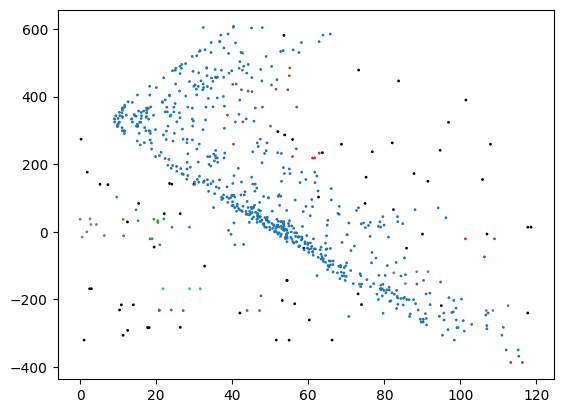

In [18]:
plt.figure()
plt.scatter((picks_window["timestamp"]-t0).dt.total_seconds(), picks_window["y(km)"], c=picks_window["label"].apply(mapping_color), s=1)

In [19]:
config_ = {"xlim_km": config["x(km)"], "ylim_km": config["y(km)"], "zlim_km": config["z(km)"]}
# estimator = EQLoc(config_, event_loc=np.array([x0, y0, z0]), event_t=(origin_time - t0).total_seconds())
estimator = EQLoc(config_)
tt = estimator.predict(X[["x_km", "y_km", "z_km", "vel"]].values)
estimator.score(X[["x_km", "y_km", "z_km", "vel"]].values, y=X["t_s"].values)

R2=-2.2715899729219156


-2.2715899729219156

In [20]:
estimator

EQLoc(config={'xlim_km': (-486.29893938501783, 486.2989393850155),
              'ylim_km': (-610.6165417479444, 611.185297582399),
              'zlim_km': (0, 30)},
      event_loc=array([-1.16529009e-12,  2.84377917e-01,  1.50000000e+01]),
      event_t=0)

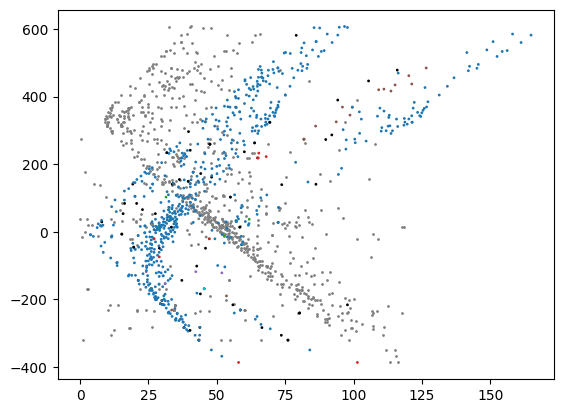

In [21]:
plt.figure()
plt.scatter((picks_window["timestamp"]-t0).dt.total_seconds(), picks_window["y(km)"], c="gray", s=1)
plt.scatter(tt, picks_window["y(km)"], c=picks_window["label"].apply(mapping_color), s=1)

In [22]:
estimator.fit(X[["x_km", "y_km", "z_km", "vel"]].values, y=X["t_s"].values)
estimator.score(X[["x_km", "y_km", "z_km", "vel"]].values, y=X["t_s"].values)
tt = estimator.predict(X[["x_km", "y_km", "z_km", "vel"]].values)

R2=-0.036700862697339076


In [23]:
estimator

EQLoc(config={'xlim_km': (-486.29893938501783, 486.2989393850155),
              'ylim_km': (-610.6165417479444, 611.185297582399),
              'zlim_km': (0, 30)},
      event_loc=array([-315.19227608,  256.7879972 ,   62.49845033]),
      event_t=3.8129932262668307)

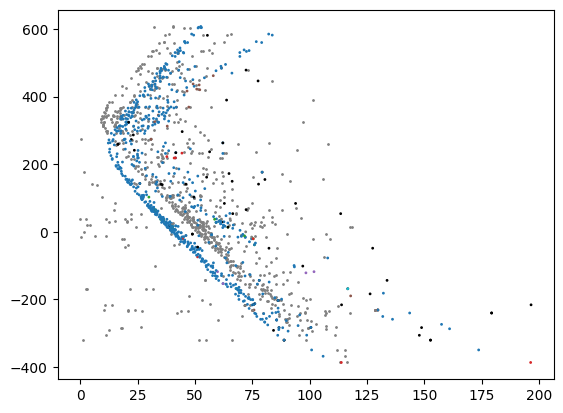

In [24]:
plt.figure()
plt.scatter((picks_window["timestamp"]-t0).dt.total_seconds(), picks_window["y(km)"], c="gray", s=1)
plt.scatter(tt, picks_window["y(km)"], c=picks_window["label"].apply(mapping_color), s=1)

In [39]:
# reg = RANSACRegressor(estimator=EQLoc(config_, event_loc=np.array([[x0, y0, 0]]), event_t=0), random_state=0, min_samples=10, residual_threshold=4.0).fit(X[["x_km", "y_km", "z_km", "vel"]].values, X["t_s"].values)
reg = RANSACRegressor(estimator=EQLoc(config_), random_state=0, min_samples=5, residual_threshold=1.0).fit(X[["x_km", "y_km", "z_km", "vel"]].values, X["t_s"].values)
mask = reg.inlier_mask_

R2=0.9995535439305946
R2=0.9991920007026228
R2=0.9993437488655836
R2=0.9993249001569348


In [40]:
reg.estimator_

EQLoc(config={'xlim_km': (-486.29893938501783, 486.2989393850155),
              'ylim_km': (-610.6165417479444, 611.185297582399),
              'zlim_km': (0, 30)},
      event_loc=array([-397.22927514,  328.45377092,  -53.44244821]),
      event_t=2.9726004282284606)

In [41]:
tt = reg.predict(X[["x_km", "y_km", "z_km", "vel"]].values)

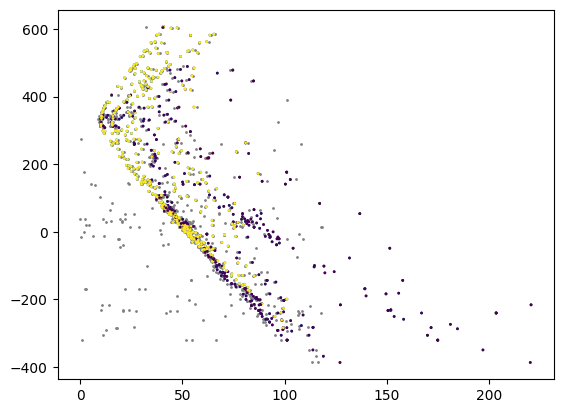

In [42]:
plt.figure()
plt.scatter((picks_window["timestamp"]-t0).dt.total_seconds(), picks_window["y(km)"], c="gray", s=1)
plt.scatter(tt, picks_window["y(km)"], c=picks_window["label"].apply(mapping_color), s=1)
plt.scatter(tt, picks_window["y(km)"], c=mask, s=1)

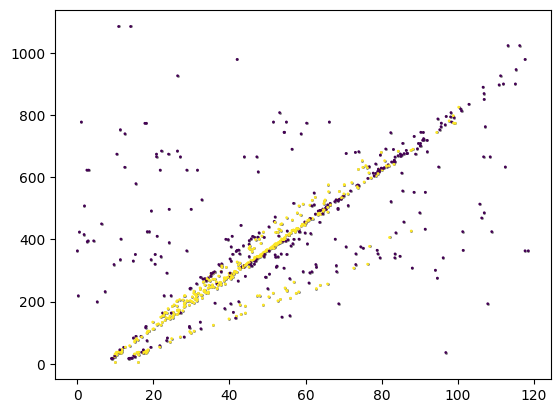

In [43]:
plt.figure()
plt.scatter((picks_window["timestamp"]-t0).dt.total_seconds(), picks_window["dist_km"], c="gray", s=1)
plt.scatter((picks_window["timestamp"]-t0).dt.total_seconds(), picks_window["dist_km"], c=mask, s=1)

# plt.scatter(tt, picks_window["dist_km"], c=picks_window["label"].apply(mapping_color), s=1)
# plt.scatter(tt, picks_window["dist_km"], c=mask, s=1)

In [38]:
raise

RuntimeError: No active exception to reraise